In [1]:
import tensorflow as tf
from tensorflow import keras
import shutil
import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
from operator import itemgetter
#from PIL import Image
#from PIL import ImageFilter

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import datasets, layers, models, losses

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
num_classes = 42
EPOCHS = 15
BS = 32

In [5]:
train_dirs = glob.glob("data_rawdata/*")

train_dirs.sort()
# print(train_dirs)
train_dirs = train_dirs[:num_classes]
print(train_dirs)
data = []
labels = []

['data_rawdata/00', 'data_rawdata/01', 'data_rawdata/02', 'data_rawdata/03', 'data_rawdata/04', 'data_rawdata/05', 'data_rawdata/06', 'data_rawdata/07', 'data_rawdata/08', 'data_rawdata/09', 'data_rawdata/10', 'data_rawdata/11', 'data_rawdata/12', 'data_rawdata/13', 'data_rawdata/14', 'data_rawdata/15', 'data_rawdata/16', 'data_rawdata/17', 'data_rawdata/18', 'data_rawdata/19', 'data_rawdata/20', 'data_rawdata/21', 'data_rawdata/22', 'data_rawdata/23', 'data_rawdata/24', 'data_rawdata/25', 'data_rawdata/26', 'data_rawdata/27', 'data_rawdata/28', 'data_rawdata/29', 'data_rawdata/30', 'data_rawdata/31', 'data_rawdata/32', 'data_rawdata/33', 'data_rawdata/34', 'data_rawdata/35', 'data_rawdata/36', 'data_rawdata/37', 'data_rawdata/38', 'data_rawdata/39', 'data_rawdata/40', 'data_rawdata/41']


In [6]:
for train_dir in tqdm(train_dirs):
  imgPaths = glob.glob(train_dir + "/*.jpg")
  imgPaths.sort()
  for imgPath in tqdm(imgPaths):
    
    image = load_img(imgPath, target_size=(28, 28), grayscale=True)
    image = img_to_array(image) 
    data.append(image)

    label = imgPath.split(os.path.sep)[-2]
    label = int(label)
    labels.append(label)

data = np.array(data, dtype=np.float) / 255.
labels = np.array(labels)

# print(data)

 29%|██▉       | 566/1961 [00:00<00:00, 2932.94it/s]


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


In [10]:
print(data.shape, labels.shape)
print(type(data), type(labels))

(79558, 28, 28, 1) (79558,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [11]:
train_input, test_input, train_target, test_target = train_test_split(data,
                                                                        labels,
                                                                        test_size=0.25,
                                                                        random_state=123)
valid_input, valid_target = train_input[-5000:], train_target[-5000:]
train_input, train_target = train_input[:-5000], train_target[:-5000]

print("train_input", train_input.shape)
print("train_target", train_target.shape)
print("test_input", test_input.shape)
print("test_target", test_target.shape)
print("valid_input", valid_input.shape)
print("valid_target", valid_target.shape)

train_input (54668, 28, 28, 1)
train_target (54668,)
test_input (19890, 28, 28, 1)
test_target (19890,)
valid_input (5000, 28, 28, 1)
valid_target (5000,)


In [12]:
train_target = to_categorical(train_target, num_classes=num_classes)
test_target = to_categorical(test_target, num_classes=num_classes)
valid_target = to_categorical(valid_target, num_classes=num_classes)

In [13]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1)

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(20, 5, padding='same',input_shape=(28,28,1)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2, strides=2))

model.add(layers.Conv2D(50, 5, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2, strides=2))


model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)             

In [19]:
model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [25]:
# path_checkpoint = "Model/model.h5"
path_checkpoint2="Model/check/model.h5"

checkpoint = ModelCheckpoint(path_checkpoint2,
                             monitor="val_acc",
                             verbose=1,
                             save_best_only=True,
                             mode = 'max')


history = model.fit(train_input, train_target, batch_size=BS, epochs=EPOCHS, verbose=1, validation_data=(valid_input, valid_target), callbacks=[checkpoint])

Epoch 1/15
1709/1709 [==============================] - 56s 33ms/step - loss: 0.2557 - accuracy: 0.9073 - val_loss: 0.2893 - val_accuracy: 0.8952
Epoch 2/15
1709/1709 [==============================] - 52s 30ms/step - loss: 0.1848 - accuracy: 0.9304 - val_loss: 0.2673 - val_accuracy: 0.9070
Epoch 3/15
1709/1709 [==============================] - 53s 31ms/step - loss: 0.1451 - accuracy: 0.9453 - val_loss: 0.2322 - val_accuracy: 0.9160
Epoch 4/15
1709/1709 [==============================] - 52s 30ms/step - loss: 0.1152 - accuracy: 0.9555 - val_loss: 0.2253 - val_accuracy: 0.9294
Epoch 5/15
1709/1709 [==============================] - 60s 35ms/step - loss: 0.0989 - accuracy: 0.9620 - val_loss: 0.2565 - val_accuracy: 0.9174
Epoch 6/15
1709/1709 [==============================] - 60s 35ms/step - loss: 0.0849 - accuracy: 0.9667 - val_loss: 0.2616 - val_accuracy: 0.9222
Epoch 7/15
1709/1709 [==============================] - 59s 35ms/step - loss: 0.0746 - accuracy: 0.9705 - val_loss: 0.2487 -

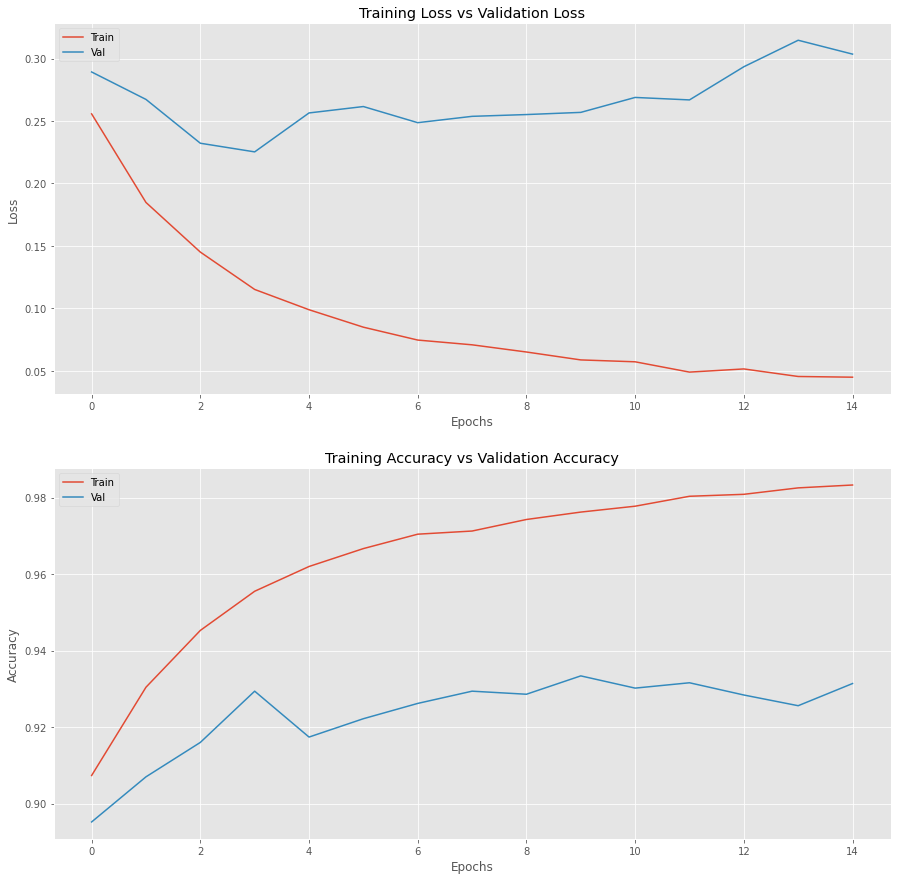

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])


(1, 28, 28, 1)


(-0.5, 399.5, 399.5, -0.5)

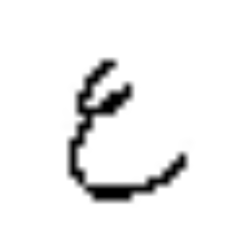

In [27]:
image = load_img("test/d30_.png", target_size=(28, 28), grayscale=True)
image = img_to_array(image) / 255.
orig_img = image.copy()
image = np.expand_dims(image, 0)
print(image.shape)

output = cv2.resize(orig_img, (400, 400))
plt.imshow(output, cmap="gray")
plt.axis("off")

In [28]:
path_checkpoint2="Model/check/model.h5"

model.load_weights(path_checkpoint2)
predictions = model.predict(image)[0]

In [36]:
label = np.argmax(predictions)
proba = np.max(predictions)
labell = "{}: {:.2f}%".format(label, proba * 100)


farsi_digits = [
    '۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹',
    'ا', 'ب', 'پ', 'ت', 'ث', 'ج', 'چ', 'ح', 'خ', 'د',
    'ذ', 'ر', 'ز', 'ژ', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ',
    'ع', 'غ', 'ف', 'ق', 'ک', 'گ', 'ل', 'م', 'ن', 'و',
    'ه', 'ی',
]

In [42]:
print("Character is: ", farsi_digits[label], " with accuracy of:", predictions[label])
# print(predictions)

Character is:  ع  with accuracy of: 0.78404224
